# Capstone Project: Board Games Recommender
____________

# Part 3 - Deep Neural Network Recommender

### Riche Ngo, SG-DSI-18

In this notebook, we will explore how to use neural network embeddings to develop a model-based recommender system utilizing the data on BGG user ratings and board game features.

Neural network embeddings are a representation of discrete variables as continuous vectors. It can be seen as a mapping tool that translates high-dimensional categorical variables to a relatively low-dimensional space. These entity embeddings can be learned by models/networks as it tries to capture the semantics of the input by placing semantically similar inputs close together in the embedding space. This method became increasingly important as we start to handle real-world unstructured data. Imagine if we had to [one-hot encode](https://en.wikipedia.org/wiki/One-hot) a dataset which contains 30,000 categories, we would end up with a 30,000 dimension vector for each item! Moreover, one-hot encoded data would not be able to indicate any similarity between the items. This is where entity embedding shines, not only being able to reduce the dimensionality of each vector representation, it could also keep similar items "closer" to one another in the embedding space. 

Once we have the trained embeddings for the users and items, we can find the most similar item by computing the distance between the embedded vectors. From there, recommendations can be made. This method make machine learning models more efficient and has seen many practical applications in Natural Language Processing (NLP) due to the vast vocabulary of words. Because there are many board game features and over 6 million user ratings in the past 3 years, we see a good opportunity to apply embedding techniques while developing a neural network recommender system.

### Contents:
- [Preprocessing](#Preprocessing)
- [Retrieval Model](#Retrieval-Model)
- [Ranking Model](#Ranking-Model)
- [Deep Features-rich Model](#Deep-Features-rich-Model)
- [Fine-tuning Model](#Fine-tuning-Model)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sqlite3
import os
import pprint
import tempfile
from typing import Dict, Text

import cv2

# Recommender
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow.keras.layers.experimental.preprocessing import StringLookup, TextVectorization, Normalization, Discretization, Hashing
from tensorflow.keras.layers import Embedding, Dense, Layer, GlobalAveragePooling1D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds


### Import data  

Import the cleaned dataframe, reference dictionaries, and user ratings.

In [2]:
# Open dataframe
infile = open('../datasets/boardgames/clean_bgg_GameItem.pkl', 'rb')
df = pickle.load(infile)
infile.close()

In [3]:
df.shape

(7929, 20)

In [4]:
# Open dictionaries
infile = open('../datasets/boardgames/ref_dictionaries.pkl', 'rb')
ref_dicts = pickle.load(infile)
infile.close()

In [5]:
# Open user ratings
infile = open('../datasets/boardgames/bgg_users_2018.pkl', 'rb')
user_df = pickle.load(infile)
infile.close()

,bgg_user_name,bgg_id,bgg_user_rating,year,month,user_count
0,-=yod@=-,463,9.0,2018,3,82
1,-=yod@=-,478,6.0,2020,1,82
2,-=yod@=-,2651,7.0,2020,11,82
3,-=yod@=-,16772,9.0,2019,3,82
4,-=yod@=-,17133,7.0,2019,12,82


In [7]:
user_df.shape

(7788605, 6)

## Preprocessing

We want to also mirror the preprocessing done in the previous notebook for collaborative filtering, except we will utilize a larger user dataframe (users with at least 30 rates) instead.

In [8]:
# Filtering dataframe to contain users with at least 30 rates
user_df = user_df[user_df['user_count']>=30]
user_df.shape

(6506411, 6)

In [9]:
# Filtering dataframe to user ratings of the board games we are concerned with
user_df = user_df[user_df['bgg_id'].isin(df['bgg_id'])]
user_df.shape

(5656674, 6)

In [10]:
user_df['user_count'].describe()

count    5.656674e+06
mean     1.968501e+02
std      2.686852e+02
min      3.000000e+01
25%      6.800000e+01
50%      1.270000e+02
75%      2.380000e+02
max      6.187000e+03
Name: user_count, dtype: float64

#### Board Game Mapper

We require a mapper for board game id to the board game name since our predictions would be done on the board game ids. This mapper will be user at the end after an actual prediction has been made.

In [12]:
# Mapper (bgg_id -> name)
bg_mapper = {}
for i, name in zip(df['bgg_id'], df['name']):
    bg_mapper[str(i)] = name

#### Unique id  

We require to map the board game ids to embedding vectors in the models later. Hence, we need lists of the unique board game ids and unique user ids.

In [13]:
# Extract unique users and unique board game ids
# Need to keep it as numpy.ndarray
unique_user = user_df['bgg_user_name'].unique()
unique_bgg_id = df['bgg_id'].unique().astype(str)

In [14]:
unique_bgg_id[:10]

array(['3', '9', '10', '11', '12', '13', '14', '16', '17', '25'],
      dtype='<U21')

## Retrieval Model

This is a two-tower retrieval model, we will build each tower separately and then combine them in the final model.

#### Split into train and test sets

We want to split the user dataframe into train and test sets, by time. The data up to time $T$ would be used to predict user rating after $T$.

In [15]:
# Sort user dataframe by date
user_df = user_df.sort_values(by=['year', 'month']).reset_index(drop=True)

In [16]:
# Split dataset with shuffle False
# We only need the user name and bgg_id
user_train, user_test = train_test_split(user_df[['bgg_id', 'bgg_user_name']], shuffle=False, test_size=0.2)

In [17]:
user_train.tail(2)

,bgg_id,bgg_user_name
4525337,231581,mtibol
4525338,245638,mtibol


In [18]:
user_test.head(2)

,bgg_id,bgg_user_name
4525339,257501,mtibol
4525340,25292,mtjake


In [19]:
# Convert train and test into Tensor Datasets
user_train['bgg_id'] = user_train['bgg_id'].astype(str)
user_test['bgg_id'] = user_test['bgg_id'].astype(str)
user_train = tf.data.Dataset.from_tensor_slices(user_train).map(lambda x: {'bgg_id': x[0], 'bgg_user_name': x[1]})
user_test = tf.data.Dataset.from_tensor_slices(user_test).map(lambda x: {'bgg_id': x[0], 'bgg_user_name': x[1]})

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

#### Query & Candidate towers

The query tower will be used to embed the user name into vectors while the candidate tower will embed the board game ids into vectors. When getting predictions, we would be sending in the user name into the query tower and predict the top-N candidates from the candidate tower.

In [20]:
# Query tower
# Dimensionality of the query
embedding_dimension = 32

# Define the model
user_model = Sequential([
    StringLookup(vocabulary=unique_user, mask_token=None),
    # Additional embedding to account for unknown tokens
    Embedding(len(unique_user) + 1, embedding_dimension)
])

In [21]:
# Candidate tower
# Define the model for board game names
bg_model = tf.keras.Sequential([
    StringLookup(vocabulary=unique_bgg_id, mask_token=None),
    Embedding(len(unique_bgg_id) + 1, embedding_dimension)
])

#### Metrics

In the training data, there are positive (bgg_id, bgg_user_name) pairs. To gauge on how good the model is, we need to compare the affinity score that the model calculates for a particular pair to the scores of all the other possible candidates. In other words, the higher the score for the positive pair as compared to other candidates, the more accurate the model is.

We use `FactorizedTopK` metric which requires the dataset of candidates that are used as implicit negatives for evaluation. We are implicitly assuming that if a user did not rate a board game, he/she do not like that board game as much.

In [22]:
# Convert to Tensor Dataset object
bgg_ids = tf.data.Dataset.from_tensor_slices(df['bgg_id'].values.astype(str))

# The metrics
metrics = tfrs.metrics.FactorizedTopK(
    candidates=bgg_ids.batch(256).map(bg_model)
)

#### Loss

We use the `Retrieval` task object to bundle together the loss function and metric computation. This becomes a Keras layer that takes the embeddings from the two towers as arguments, and returning the computed loss.

In [23]:
# Setting up the task
task = tfrs.tasks.Retrieval(
    metrics=metrics
)

#### Full model

We want to combine all of the above together into a model. We use `tfrs.Model` as the base model which take care of creating the appropriate training loop to fit the model.

In [24]:
# Check the format of train and test datasets
count = 0

for element in user_test.as_numpy_iterator():
    if count <=10:
        print(element)
        count += 1
    else:
        break

{'bgg_id': b'257501', 'bgg_user_name': b'mtibol'}
{'bgg_id': b'25292', 'bgg_user_name': b'mtjake'}
{'bgg_id': b'108745', 'bgg_user_name': b'mtlfan8'}
{'bgg_id': b'192291', 'bgg_user_name': b'mtlfan8'}
{'bgg_id': b'150997', 'bgg_user_name': b'mtnfrost'}
{'bgg_id': b'163642', 'bgg_user_name': b'mtnturtle'}
{'bgg_id': b'263918', 'bgg_user_name': b'mtnturtle'}
{'bgg_id': b'138161', 'bgg_user_name': b'mtnw'}
{'bgg_id': b'139898', 'bgg_user_name': b'mtnw'}
{'bgg_id': b'284083', 'bgg_user_name': b'mtnw'}
{'bgg_id': b'13122', 'bgg_user_name': b'mtostam'}


In [25]:
# Full model
class BGRetrievalModel(tfrs.Model):
    
    def __init__(self, user_model, bg_model):
        super().__init__()
        self.bg_model: tf.keras.Model = bg_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task
    
    def compute_loss(self, features, training=False) -> tf.Tensor:
        # Picking out the user features and passing them into the user model
        # Format of each entry is ['bgg_id', 'bgg_user_name']
        user_embeddings = self.user_model(features['bgg_user_name'])
        
        # Picking out the board games features, passing into bg model
        positive_bg_embeddings = self.bg_model(features['bgg_id'])
        
        # Task computes the loss and the metrics
        return self.task(user_embeddings, positive_bg_embeddings)

### Fitting and Evaluation  

In [26]:
# Instantiate and compile the model
retrieval_model = BGRetrievalModel(user_model, bg_model)
retrieval_model.compile(optimizer=Adagrad(learning_rate=0.1))

In [27]:
# Batch and cache the datasets, did not shuffle to keep time order
cached_user_train = user_train.batch(16384).cache()
cached_user_test = user_test.batch(8192).cache()

In [29]:
# Training the model
tf.random.set_seed(42)
retrieval_model.fit(cached_user_train, epochs=5)

Epoch 1/5
277/277 [==============================] - 709s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0113 - factorized_top_k/top_10_categorical_accuracy: 0.0202 - factorized_top_k/top_50_categorical_accuracy: 0.0745 - factorized_top_k/top_100_categorical_accuracy: 0.1251 - loss: 155593.0624 - regularization_loss: 0.0000e+00 - total_loss: 155593.0624
Epoch 2/5
277/277 [==============================] - 683s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0140 - factorized_top_k/top_10_categorical_accuracy: 0.0262 - factorized_top_k/top_50_categorical_accuracy: 0.0977 - factorized_top_k/top_100_categorical_accuracy: 0.1590 - loss: 151159.1000 - regularization_loss: 0.0000e+00 - total_loss: 151159.1000
Epoch 3/5
277/277 [==============================] - 688s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_acc

In [30]:
# Evaluate the model
retrieval_model.evaluate(cached_user_test, return_dict=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

{'factorized_top_k/top_1_categorical_accuracy': 0.0008529745973646641,
 'factorized_top_k/top_5_categorical_accuracy': 0.005297281313687563,
 'factorized_top_k/top_10_categorical_accuracy': 0.010723614133894444,
 'factorized_top_k/top_50_categorical_accuracy': 0.04754648357629776,
 'factorized_top_k/top_100_categorical_accuracy': 0.08439233154058456,
 'loss': 5511.63623046875,
 'regularization_loss': 0,
 'total_loss': 5511.63623046875}

These values tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-50 categorical accuracy metric of 0.3 means that 30% of the top 50 retrieved items are true positives.

Comparing the metrics, there is a considerable difference between the train and test accuracies, suggesting that the model has been overfitted. It is common since the model has many parameters. A low top-k accuracy would also suggest that the model is recommending board games to users who already rated those board games.

(Maybe can try regularization to generalize better to unseen data.)

### Predictions

We want to test out the recommender system by sending in a user name and picking out the top recommendations from the list of candidates.

In [31]:
# Board game dataset needs to be Tensorflow object
bgg_ids

<TensorSliceDataset shapes: (), types: tf.string>

In [32]:
# Create a model that takes in raw query features
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model)

# Recommends a board game out of the entire boardgame dataset
index.index(bgg_ids.batch(128).map(retrieval_model.bg_model), bgg_ids)

In [122]:
# Get recommendation
_, board_games = index(tf.constant(['-mide-']))
print(f'Recommendations for -mide-: {board_games[0, :3]}')

Recommendations for -mide-: [b'245353' b'258413' b'229598']


We are able to successfully recommend top 3 games (number of games arbituarily decided) to a user with the username '-johnny-' based on the trained embeddings for both the query tower and candidate tower. However, we are recommending the board game id right now, and we want to map that to the board game name for it to be more meaningful. 

In [123]:
# Map the predicted bgg_id to the board game name
named_games = []
for bgg_id in board_games[0, :3]:
    named_games.append(bg_mapper[bgg_id.numpy().decode("utf-8")])

print(f'Recommendations for -mide-: {named_games}')

Recommendations for -mide-: ['Unlock!: Secret Adventures – Tombstone Express', "Unlock!: Exotic Adventures – Scheherazade's Last Tale", 'Unlock!: Escape Adventures – Doo-Arann Dungeon']


In [124]:
# Check if our model is re-recommending the user a game he or she has already played
user_df[user_df['bgg_user_name']=='-mide-']

,bgg_user_name,bgg_id,bgg_user_rating,year,month,user_count
1,-mide-,124,7.5,2018,1,66
2,-mide-,24480,7.5,2018,1,66
3,-mide-,37380,7.0,2018,1,66
4,-mide-,39683,8.0,2018,1,66
5,-mide-,54043,8.0,2018,1,66
6,-mide-,83330,8.0,2018,1,66
7,-mide-,102652,7.5,2018,1,66
8,-mide-,128271,8.5,2018,1,66
9,-mide-,161936,8.5,2018,1,66
10,-mide-,161970,8.0,2018,1,66


Observing the board games which the user has rated, we see that the top 3 recommended games are not within them. This is still a good sign, but it may be just so happened that these entries have no false positives. 

The retrieval model is useful for getting quick recommendations, but it is just based on the board game ids and user ids. This model is usually built to be more computationally efficient to filter out all candidates that the user is not interested in.

## Ranking Model

The ranking model is built to select the best possible recommendations based on the user ratings for the board games. It comprises of a `Ranking` task which learns to predict the ratings of the board games. Based on these predictions, the best recommendations could be selected.

#### Split into train and test sets

The train and test data will now include the user ratings to give a sense of ranking to the recommended board games.

In [36]:
rating_train, rating_test = train_test_split(user_df[['bgg_id', 'bgg_user_name', 'bgg_user_rating']], shuffle=False, test_size=0.2)

In [37]:
# Convert train and test into Tensor Datasets
rating_train = tf.data.Dataset.from_tensor_slices({'bgg_id': rating_train['bgg_id'].astype(str),
                                                  'bgg_user_name': rating_train['bgg_user_name'],
                                                  'bgg_user_rating': rating_train['bgg_user_rating'].astype('float32')})
rating_test = tf.data.Dataset.from_tensor_slices({'bgg_id': rating_test['bgg_id'].astype(str),
                                                  'bgg_user_name': rating_test['bgg_user_name'],
                                                  'bgg_user_rating': rating_test['bgg_user_rating'].astype('float32')})

In [38]:
rating_train

<TensorSliceDataset shapes: {bgg_id: (), bgg_user_name: (), bgg_user_rating: ()}, types: {bgg_id: tf.string, bgg_user_name: tf.string, bgg_user_rating: tf.float32}>

#### Ranking layers

The ranking model is composed of multiple layers for ranking tasks.

In [39]:
# Ranking tasks
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # User embeddings
        self.user_embeddings = Sequential([
            StringLookup(vocabulary=unique_user, mask_token=None),
            Embedding(len(unique_user) + 1, embedding_dimension)
        ])

        # Board game embeddings
        self.bg_embeddings = Sequential([
            StringLookup(vocabulary=unique_bgg_id, mask_token=None),
            Embedding(len(unique_bgg_id) + 1, embedding_dimension)
        ])

        # Predictions
        self.ratings = Sequential([
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
          # Rating predictions in the final layer.
            Dense(1)
        ])
    
    def call(self, inputs):
        bgg_user_name, bgg_id = inputs
        user_embedding = self.user_embeddings(bgg_user_name)
        bg_embedding = self.bg_embeddings(bgg_id)
        return self.ratings(tf.concat([user_embedding, bg_embedding], axis=1))

In [40]:
# This model takes user names and bgg ids, and outputs a predicted rating
RankingModel()((['-johnny-'],['20545']))

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00607153]], dtype=float32)>

#### Loss and metrics

This time, we use the `Ranking` task object to put together the loss function and metric computation. The metrics used is `RootMeanSquaredError`.

In [41]:
# The loss + metrics task
task = tfrs.tasks.Ranking(
    loss = MeanSquaredError(),
    metrics = [RootMeanSquaredError()]
)

#### Full model

We want to combine all of the above together into a model. We use `tfrs.Model` as the base model which take care of creating the appropriate training loop to fit the model.

In [42]:
# Check the format of train and test datasets
count = 0
for element in rating_test.as_numpy_iterator():
    if count <=10:
        print(element)
        count += 1
    else:
        break

{'bgg_id': b'257501', 'bgg_user_name': b'mtibol', 'bgg_user_rating': 9.0}
{'bgg_id': b'25292', 'bgg_user_name': b'mtjake', 'bgg_user_rating': 9.0}
{'bgg_id': b'108745', 'bgg_user_name': b'mtlfan8', 'bgg_user_rating': 10.0}
{'bgg_id': b'192291', 'bgg_user_name': b'mtlfan8', 'bgg_user_rating': 8.5}
{'bgg_id': b'150997', 'bgg_user_name': b'mtnfrost', 'bgg_user_rating': 8.5}
{'bgg_id': b'163642', 'bgg_user_name': b'mtnturtle', 'bgg_user_rating': 7.0}
{'bgg_id': b'263918', 'bgg_user_name': b'mtnturtle', 'bgg_user_rating': 8.0}
{'bgg_id': b'138161', 'bgg_user_name': b'mtnw', 'bgg_user_rating': 8.0}
{'bgg_id': b'139898', 'bgg_user_name': b'mtnw', 'bgg_user_rating': 6.5}
{'bgg_id': b'284083', 'bgg_user_name': b'mtnw', 'bgg_user_rating': 7.0}
{'bgg_id': b'13122', 'bgg_user_name': b'mtostam', 'bgg_user_rating': 8.8}


In [43]:
# Full model
class BGRankingModel(tfrs.Model):
    
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        # The loss + metrics task
        self.task: Layer = tfrs.tasks.Ranking(
            loss = MeanSquaredError(),
            metrics = [RootMeanSquaredError()]
        )
    
    def compute_loss(self, features, training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model(
            (features['bgg_user_name'], features['bgg_id']))
        
        # Task computes the loss and the metrics
        return self.task(labels=features['bgg_user_rating'], predictions=rating_predictions)

### Fitting and Evaluation

In [44]:
# Instantiate and compile the model
ranking_model = BGRankingModel()
ranking_model.compile(optimizer=Adagrad(learning_rate=0.1))

In [45]:
# Batch and cache the datasets, did not shuffle to keep time order
cached_rating_train = rating_train.batch(16384).cache()
cached_rating_test = rating_test.batch(8192).cache()

In [46]:
# Check the format of train and test datasets
count = 0
for element in rating_test.as_numpy_iterator():
    if count <=2:
        print(element)
        count += 1
    else:
        break

{'bgg_id': b'257501', 'bgg_user_name': b'mtibol', 'bgg_user_rating': 9.0}
{'bgg_id': b'25292', 'bgg_user_name': b'mtjake', 'bgg_user_rating': 9.0}
{'bgg_id': b'108745', 'bgg_user_name': b'mtlfan8', 'bgg_user_rating': 10.0}


In [47]:
# Training the model
tf.random.set_seed(42)
ranking_model.fit(cached_rating_train, epochs=5)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
277/277 [==============================] - 11s 38ms/step - root_mean_squared_error: 1.5642 - loss: 2.4399 - regularization_loss: 0.0000e+00 - total_loss: 2.4399
Epoch 2/5
277/277 [==============================] - 6s 23ms/step - root_mean_squared_error: 1.2966 - loss: 1.6785 - regularization_loss: 0.0000e+00 - total_loss: 1.6785
Epoch 3/5
277/277 [==============================] - 6s 23m

In [48]:
# Evaluate the model
ranking_model.evaluate(cached_rating_test, return_dict=True)

139/139 [==============================] - 2s 14ms/step - root_mean_squared_error: 1.2859 - loss: 1.6519 - regularization_loss: 0.0000e+00 - total_loss: 1.6519


{'root_mean_squared_error': 1.2859489917755127,
 'loss': 1.5264127254486084,
 'regularization_loss': 0,
 'total_loss': 1.5264127254486084}

We observe that the rmse and loss are both very similar to that of the train data, which is good.

### Predictions

We are unable to directly make predictions using the Ranking Model because there is not query model built-in, it is optimized on simply predicting the ratings of the board games. It would not make any sense to generate rating predictions for every other board game which a single user did not rate before due to computational inefficiency. Therefore, the Ranking Model is usually implemented in tandem with the retrieval model, where the Retrieval Model will sieve out an initial set of candidates from all possible candidates, and the Ranking Model will take the outputs and fine-tunes them to select the highly rated board games as recommendations.

## Deep Features-rich Model 

We want to utilize the vast features we have for the board games.

### Features Preprocessing

#### Lookup vocabulary

We want to define a vocabulary for both board games and users.

In [319]:
bgg_ids

<TensorSliceDataset shapes: (), types: tf.string>

In [54]:
# Vocabulary for bgg_id
bgg_id_lookup = StringLookup()
bgg_id_lookup.adapt(bgg_ids)

In [55]:
bgg_id_lookup.vocab_size()

7931

In [56]:
# Test the layer out with bgg ids
# Note that bgg_id = 2 is not in the list
bgg_id_lookup(['3', '9', '2'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1814,  227,    1], dtype=int64)>

In [57]:
# Vocabulary for user names
user_lookup = StringLookup()
user_lookup.adapt(tf.data.Dataset.from_tensor_slices(unique_user))

In [58]:
user_lookup.vocab_size()

66949

#### Continuous features

Complexity is an important continuous feature to use in the model. The reason it is continuous is that the value reflects the average complexity rating as contributed by the BGG community. We can discretize the complexity to a pre-defined number of buckets, since it is reasonable to assume that board games with very similar complexity will fall within the same range of complexity.

In [59]:
# Standardize the feature
complexity_normalization = Normalization()
complexity_normalization.adapt(tf.data.Dataset.from_tensor_slices(df['complexity']).batch(512))

In [60]:
# Test normalization
complexity_normalization(df['complexity'].values[:5])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.39823163],
       [ 1.3151934 ],
       [-0.03692577],
       [-0.6782308 ],
       [ 0.2137556 ]], dtype=float32)>

In [70]:
# Set the number of discretized buckets
# Min complexity is 1, Max is 5
complexity_buckets = np.linspace(1, 5, num=50)

#### Categorical features

We will include some of the board game features which are less controversial when people consider board game recommendations. In other words, features such as designer, artist, or publisher will not be included since it is difficult to assume whether people are seeking for more serendipity or not within these features.

In [61]:
# Custom splitting function
def split_on_comma(input_data):
    return tf.strings.split(input_data, sep=',')

max_tokens = 10_000
# Vectorization of game types
vec_game_types = TextVectorization(max_tokens=max_tokens, standardize=None, split=split_on_comma)
vec_game_types.adapt(tf.data.Dataset.from_tensor_slices(df['game_type']).batch(512))

# Vectorization of categories
vec_categories = TextVectorization(max_tokens=max_tokens, standardize=None, split=split_on_comma)
vec_categories.adapt(tf.data.Dataset.from_tensor_slices(df['category']).batch(512))

# Vectorization of mechanics
vec_mechanics = TextVectorization(max_tokens=max_tokens, standardize=None, split=split_on_comma)
vec_mechanics.adapt(tf.data.Dataset.from_tensor_slices(df['mechanic']).batch(512))

In [62]:
# Testing out the vectorization on game types
for value in tf.constant(df['game_type'].sample(20, random_state=42)):
    tf.print("Game type:", value)
    tf.print("Vectorized game types:", vec_game_types(value))
    print('------------------------------')

Game type: "99999"
Vectorized game types: [2]
------------------------------
Game type: "4665"
Vectorized game types: [9]
------------------------------
Game type: "5496"
Vectorized game types: [6]
------------------------------
Game type: "5496"
Vectorized game types: [6]
------------------------------
Game type: "4664"
Vectorized game types: [5]
------------------------------
Game type: "99999"
Vectorized game types: [2]
------------------------------
Game type: "99999"
Vectorized game types: [2]
------------------------------
Game type: "99999"
Vectorized game types: [2]
------------------------------
Game type: "5496,5498"
Vectorized game types: [6 7]
------------------------------
Game type: "5496"
Vectorized game types: [6]
------------------------------
Game type: "5498"
Vectorized game types: [7]
------------------------------
Game type: "5497"
Vectorized game types: [3]
------------------------------
Game type: "5497"
Vectorized game types: [3]
------------------------------
G

In [63]:
# Testing out the vectorization on categories
for value in tf.constant(df['category'].sample(20, random_state=42)):
    tf.print("Categories:", value)
    tf.print("Vectorized categories:", vec_categories(value))
    print('------------------------------')

Categories: "1002,1010"
Vectorized categories: [2 3]
------------------------------
Categories: "1032,1041,1017,1031"
Vectorized categories: [21 22 6 32]
------------------------------
Categories: "1022,1010,1046,1047"
Vectorized categories: [12 3 5 10]
------------------------------
Categories: "1064,1016,1019"
Vectorized categories: [28 7 4]
------------------------------
Categories: "1023,1102,1019"
Vectorized categories: [13 73 4]
------------------------------
Categories: "1021,1010,1008"
Vectorized categories: [8 3 29]
------------------------------
Categories: "1017,1031"
Vectorized categories: [6 32]
------------------------------
Categories: "1118,1030"
Vectorized categories: [77 9]
------------------------------
Categories: "1002,1028,1037"
Vectorized categories: [2 27 23]
------------------------------
Categories: "1022,1002,1020,1016"
Vectorized categories: [12 2 17 7]
------------------------------
Categories: "1024,1093,1037"
Vectorized categories: [24 35 23]
------------

In [64]:
# Testing out the vectorization on mechanics
for value in tf.constant(df['mechanic'].sample(20, random_state=42)):
    tf.print("Mechanics:", value)
    tf.print("Vectorized mechanics:", vec_mechanics(value))
    print('------------------------------')

Mechanics: "2080,2040"
Vectorized mechanics: [7 2]
------------------------------
Mechanics: "2072"
Vectorized mechanics: [3]
------------------------------
Mechanics: "2001,2046,2023,2072,2011,2028,2819,2015"
Vectorized mechanics: [11 15 10 ... 32 20 4]
------------------------------
Mechanics: "2080,2046,2072,2016,2015"
Vectorized mechanics: [7 15 3 33 4]
------------------------------
Mechanics: "2080,2046,2018,2857,2070"
Vectorized mechanics: [7 15 29 79 18]
------------------------------
Mechanics: "2013,2072,2813,2002,2663,2015,2082"
Vectorized mechanics: [44 3 65 ... 51 4 13]
------------------------------
Mechanics: "99999"
Vectorized mechanics: [31]
------------------------------
Mechanics: "2040"
Vectorized mechanics: [2]
------------------------------
Mechanics: "2023"
Vectorized mechanics: [10]
------------------------------
Mechanics: "2023,2676,2040,2959,2011,2822,2819,2027,2015"
Vectorized mechanics: [10 12 2 ... 20 37 4]
------------------------------
Mechanics: "2893,2

In [65]:
# Use to get the vocabulary for a vectorizer
vec_mechanics.get_vocabulary()[30:35]

['2685', '99999', '2028', '2016', '2689']

#### Split into train and test sets

In [66]:
# Merge dataframes
combined_df = user_df.merge(df, how='left', on='bgg_id')
combined_df.head(10)

,bgg_user_name,bgg_id,bgg_user_rating,year_x,month,user_count,name,year_y,game_type,designer,...,min_time,max_time,category,mechanic,rank,num_votes,avg_rating,stddev_rating,bayes_rating,complexity
0,-=yod@=-,174430,10.0,2018,1,82,Gloomhaven,2017,"5496,5497",69802,...,60.0,120.0,"1022,1020,1010,1046,1047","2689,2839,2018,2857,2893,2023,3004,2664,2676,2...",1.0,40523.0,8.80123,1.61052,8.55722,3.8515
1,-mide-,124,7.5,2018,1,66,Primordial Soup,1997,5497,"74,75",...,90.0,90.0,1036,"2957,2072,2676,2015",900.0,4525.0,6.94404,1.32455,6.56879,2.7308
2,-mide-,24480,7.5,2018,1,66,The Pillars of the Earth,2006,5497,"142,7391",...,90.0,120.0,"1021,1035,1093,1115","2850,2985,2082,2933",293.0,16194.0,7.29077,1.19341,7.11326,2.8201
3,-mide-,37380,7.0,2018,1,66,Roll Through the Ages: The Bronze Age,2008,"5497,5499",378,...,30.0,45.0,"1050,1029,1015,1017","2072,2055,2870,2819",702.0,11436.0,6.87595,1.17720,6.70770,1.7782
4,-mide-,39683,8.0,2018,1,66,At the Gates of Loyang,2009,5497,10,...,60.0,120.0,"1021,1013","2041,2912,2904,2900,2004,2819",294.0,9603.0,7.38252,1.28273,7.11232,3.1290
5,-mide-,54043,8.0,2018,1,66,Jaipur,2009,5499,6736,...,30.0,30.0,"1089,1052,1002,1021","2041,2040,2823,2004",133.0,36097.0,7.51012,1.10112,7.39540,1.4935
6,-mide-,83330,8.0,2018,1,66,Mansions of Madness,2011,5496,6651,...,120.0,180.0,"1022,1020,1010,1046,1024,1047,1040,1028","2046,2072,2040,2011,2007,2028,2822,2019,2015",373.0,12680.0,7.29468,1.56197,7.01326,3.2435
7,-mide-,102652,7.5,2018,1,66,Sentinels of the Multiverse,2011,5496,"50244,50245,50243",...,30.0,60.0,"1002,1116,1046","2023,2040,2819,2015",389.0,14611.0,7.22809,1.67568,6.99270,2.4993
8,-mide-,128271,8.5,2018,1,66,Ginkgopolis,2012,5497,11312,...,45.0,45.0,"1029,1084,1016,1086","2080,2041,2020,2819,2002",407.0,4857.0,7.42686,1.31314,6.97147,2.9114
9,-mide-,161936,8.5,2018,1,66,Pandemic Legacy: Season 1,2015,"5496,5497","442,378",...,60.0,60.0,"1084,2145","2001,2023,2040,2824,2078,2004,2008,2015",2.0,40625.0,8.61598,1.57304,8.46651,2.8374


In [67]:
# Train/test split
combined_train, combined_test = train_test_split(combined_df[['bgg_id', 'bgg_user_name', 'bgg_user_rating', 'complexity', 'game_type', 'category', 'mechanic']], shuffle=False, test_size=0.2)

In [68]:
# Convert train and test into Tensor Datasets
combined_train = tf.data.Dataset.from_tensor_slices({'bgg_id': combined_train['bgg_id'].astype(str),
                                                     'bgg_user_name': combined_train['bgg_user_name'],
                                                     'bgg_user_rating': combined_train['bgg_user_rating'].astype('float32'),
                                                     'complexity': combined_train['complexity'].astype('float32'),
                                                     'game_type': combined_train['game_type'],
                                                     'category': combined_train['category'],
                                                     'mechanic': combined_train['mechanic']
                                                    })
combined_test = tf.data.Dataset.from_tensor_slices({'bgg_id': combined_test['bgg_id'].astype(str),
                                                    'bgg_user_name': combined_test['bgg_user_name'],
                                                    'bgg_user_rating': combined_test['bgg_user_rating'].astype('float32'),
                                                    'complexity': combined_test['complexity'].astype('float32'),
                                                    'game_type': combined_test['game_type'],
                                                    'category': combined_test['category'],
                                                    'mechanic': combined_test['mechanic']
                                                   })

### Model Assembly

#### Embeddings

Define the embedding layers.

In [71]:
embedding_dimension = 32
# Embedding for bgg_id
bgg_id_embedding = Embedding(input_dim=bgg_id_lookup.vocab_size(),
                            output_dim=embedding_dimension)

# Embedding for user names
user_embedding = Embedding(input_dim=user_lookup.vocab_size(),
                          output_dim=embedding_dimension)

# Embedding for complexity
complexity_embedding = Embedding(input_dim=len(complexity_buckets) + 1,
                                output_dim=embedding_dimension)

# Embeddings for categorial features
game_type_embedding = Embedding(max_tokens, embedding_dimension, mask_zero=True)
category_embedding = Embedding(max_tokens, embedding_dimension, mask_zero=True)
mechanic_embedding = Embedding(max_tokens, embedding_dimension, mask_zero=True)

#### Sub-models

In [72]:
# Model for bgg_id
bgg_id_model = Sequential([bgg_id_lookup, bgg_id_embedding])

# Model for user names
user_name_model = Sequential([user_lookup, user_embedding])

# Model for complexity
complexity_model = Sequential([complexity_embedding, complexity_normalization])

# Model for categorical features
game_type_model = Sequential([vec_game_types, game_type_embedding, GlobalAveragePooling1D()])
category_model = Sequential([vec_categories, category_embedding, GlobalAveragePooling1D()])
mechanic_model = Sequential([vec_mechanics, mechanic_embedding, GlobalAveragePooling1D()])

In [73]:
# User model
class UserModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.user_embedding: tf.keras.Model = user_name_model
        
    def call(self, inputs):
        
        return tf.concat([
            self.user_embedding(inputs['bgg_user_name'])
        ], axis=1)

In [74]:
# Board game model
class BoardGameModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.bgg_id_embedding: tf.keras.Model = bgg_id_model
        self.complexity_embedding: tf.keras.Model = complexity_model
        self.game_type_embedding: tf.keras.Model = game_type_model
        self.category_embedding: tf.keras.Model = category_model
        self.mechanic_embedding: tf.keras.Model = mechanic_model
            
    def call(self, inputs):
        return tf.concat([
            self.bgg_id_embedding(inputs['bgg_id']),
            self.complexity_embedding(inputs['complexity']),
            self.game_type_embedding(inputs['game_type']),
            self.category_embedding(inputs['category']),
            self.mechanic_embedding(inputs['mechanic'])
        ], axis=1)

#### Query & Candidate towers

In [75]:
# Query model
class QueryModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.embedding_model = UserModel()
        self.dense_layers = Sequential([
            Dense(64, activation="relu"),
            Dense(32)
        ])
    
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [76]:
# Candidate model
class CandidateModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.embedding_model = BoardGameModel()
        self.dense_layers = Sequential([
            Dense(64, activation="relu"),
            Dense(32)
        ])
    
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

#### Full model

In [77]:
tensor_candidates = tf.data.Dataset.from_tensor_slices({'bgg_id': df['bgg_id'].astype(str),
                                                        'complexity': df['complexity'].astype('float32'),
                                                        'game_type': df['game_type'],
                                                        'category': df['category'],
                                                        'mechanic': df['mechanic']
                                                       })

In [78]:
# Check the format of train and test datasets
count = 0
for element in combined_test.as_numpy_iterator():
    if count <=5:
        print(element)
        count += 1
    else:
        break

{'bgg_id': b'257501', 'bgg_user_name': b'mtibol', 'bgg_user_rating': 9.0, 'complexity': 2.456, 'game_type': b'4667', 'category': b'1002,1010,1046', 'mechanic': b'2040,2686'}
{'bgg_id': b'25292', 'bgg_user_name': b'mtjake', 'bgg_user_rating': 9.0, 'complexity': 3.2395, 'game_type': b'5496', 'category': b'1022,1046,1008,1090,1011', 'mechanic': b'2001,2046,2072,2007,2876,2015'}
{'bgg_id': b'108745', 'bgg_user_name': b'mtlfan8', 'bgg_user_rating': 10.0, 'complexity': 2.7709, 'game_type': b'5497', 'category': b'1002,1017,1010', 'mechanic': b'2041,2072,2040,2686,2874'}
{'bgg_id': b'192291', 'bgg_user_name': b'mtlfan8', 'bgg_user_rating': 8.5, 'complexity': 1.3233, 'game_type': b'5499', 'category': b'1002,1030', 'mechanic': b'2041,2875,2040,2004,2020'}
{'bgg_id': b'150997', 'bgg_user_name': b'mtnfrost', 'bgg_user_rating': 8.5, 'complexity': 3.378, 'game_type': b'5496', 'category': b'1022,1055,1020,1010,1024,1047', 'mechanic': b'2023,2072,2676,2011,2028,2015'}
{'bgg_id': b'163642', 'bgg_user_n

In [79]:
# Full model
class BGDeepModel(tfrs.models.Model):
    
    def __init__(self):
        super().__init__()
        self.query_model = QueryModel()
        self.candidate_model = CandidateModel()
        
        # Model to take in query and candidate embeddings and predict ratings
        self.rating_model = Sequential([
            Dense(256, activation="relu"),
            Dense(64, activation="relu"),
          # Rating predictions in the final layer.
            Dense(1)
        ])
        
        # Tasks
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=tensor_candidates.batch(128).map(self.candidate_model)
            )
        )
        self.rating_task = tfrs.tasks.Ranking(
            loss=MeanSquaredError(),
            metrics=[RootMeanSquaredError()]
        )
        
        
    def compute_loss(self, features, training=False):
        # Obtain embeddings
        query_embeddings = self.query_model({
            'bgg_user_name': features['bgg_user_name']
        })
        candidate_embeddings = self.candidate_model({
            'bgg_id': features['bgg_id'],
            'complexity': features['complexity'],
            'game_type': features['game_type'],
            'category': features['category'],
            'mechanic': features['mechanic']
        })
        
        # Obtain rating predictions
        ratings = features['bgg_user_rating']
        rating_predictions = self.rating_model(
            tf.concat([query_embeddings, candidate_embeddings], axis=1)
        )
        # Calculate losses
        retrieval_loss = self.retrieval_task(query_embeddings, candidate_embeddings)
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)

        return (retrieval_loss + rating_loss)

### Fitting and Evaluation

In [80]:
# Batch and cache the datasets, did not shuffle to keep time order
cached_combined_train = combined_train.batch(16_384).cache()
cached_combined_test = combined_test.batch(8192).cache()

In [81]:
# Instantiate and compile model
deep_model = BGDeepModel()
deep_model.compile(optimizer=Adagrad(0.1))

# Training the model
tf.random.set_seed(42)
deep_model.fit(cached_combined_train, epochs=5)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (o

In [82]:
# Evaluate the model
deep_model.evaluate(cached_combined_test, return_dict=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

{'factorized_top_k/top_1_categorical_accuracy': 0.0005471411859616637,
 'factorized_top_k/top_5_categorical_accuracy': 0.003871532389894128,
 'factorized_top_k/top_10_categorical_accuracy': 0.007996747270226479,
 'factorized_top_k/top_50_categorical_accuracy': 0.038035593926906586,
 'factorized_top_k/top_100_categorical_accuracy': 0.0695611834526062,
 'root_mean_squared_error': 1.3787566423416138,
 'loss': 5527.24609375,
 'regularization_loss': 0,
 'total_loss': 5527.24609375}

We see that the total loss decreased as compared to the retrieval model alone, however, the accuracy achieved is not very high. This is likely due to the fact that the model is only trained using 5 epochs and the depth (number of layers) may not be enough. We want to fine-tune this model further to improve its performance and accuracy.

In [83]:
# Save the model weights
deep_model.save_weights("../boardgames_models/deep_model_weights")

### Predictions

In [84]:
# Create a model that takes in raw query features
deep_index = tfrs.layers.factorized_top_k.BruteForce(deep_model.query_model)

# Recommends a board game out of the entire boardgame dataset
deep_index.index(tensor_candidates.batch(128).map(deep_model.candidate_model), bgg_ids)

In [90]:
# Get recommendation
_, board_games = deep_index({'bgg_user_name': tf.constant(['-mide-'])})
print(f'Recommendations for -mide-: {board_games}')

Recommendations for -mide-: [[b'217099' b'193278' b'243636' b'265430' b'126274' b'206450' b'157917'
  b'129951' b'180644' b'223996']]


In [91]:
# Map the predicted bgg_id to the board game name
named_games = []
for bgg_id in board_games[0, :]:
    named_games.append(bg_mapper[bgg_id.numpy().decode("utf-8")])

print(f'Recommendations for -mide-: {named_games}')

Recommendations for -mide-: ['Seeders from Sereis: Exodus', 'Yomi Starter Set: Grave versus Jaina', 'Immortal 8', 'Elekt', 'Enclave: Zakon Krańca Świata', 'TOP Kitchen', 'The Lord of the Ice Garden', 'Teomachia', '3 Kings', 'Minuit, Meurtre en Mer']


In [92]:
# View the recommended board games with more info
df.loc[df['name'].isin(named_games), ['bgg_id', 'name', 'complexity', 'game_type', 'category', 'mechanic']]

,bgg_id,name,complexity,game_type,category,mechanic
3091,126274,Enclave: Zakon Krańca Świata,3.2143,5496,"1022,1093,1016","2041,2079,2082"
3200,129951,Teomachia,3.0625,99999,"1050,1023,1002,1046,1082","2012,2041,2664,2040,2685"
3971,157917,The Lord of the Ice Garden,4.0571,5497,"1010,1046,1035,1082,1093,1016","2001,2689,2080,2079,2015,2082"
4746,180644,3 Kings,2.8333,99999,"1023,1039,1010,1035,1026,1001","2023,2040,2020,2079,2017"
5137,193278,Yomi Starter Set: Grave versus Jaina,2.0000,99999,"1002,1010,1046","2040,2003,2020,2015"
5538,206450,TOP Kitchen,2.0000,5499,"1017,1021","2012,2072,2040"
5785,217099,Seeders from Sereis: Exodus,3.5000,99999,"1016,1113","2012,2041,2664"
5977,223996,"Minuit, Meurtre en Mer",1.8333,99999,"1023,1039,1020,1040,1097","2001,2046,2055"
6524,243636,Immortal 8,3.0000,99999,"1015,1010",2041
7169,265430,Elekt,2.5000,99999,1010,2040


In [93]:
# View the board games which '-mide-' has already rated for comparison
combined_df.loc[combined_df['bgg_user_name']=='-mide-', ['bgg_user_name', 'bgg_user_rating', 'bgg_id', 'name', 'complexity', 'game_type', 'category', 'mechanic']]

,bgg_user_name,bgg_user_rating,bgg_id,name,complexity,game_type,category,mechanic
1,-mide-,7.5,124,Primordial Soup,2.7308,5497,1036,"2957,2072,2676,2015"
2,-mide-,7.5,24480,The Pillars of the Earth,2.8201,5497,"1021,1035,1093,1115","2850,2985,2082,2933"
3,-mide-,7.0,37380,Roll Through the Ages: The Bronze Age,1.7782,"5497,5499","1050,1029,1015,1017","2072,2055,2870,2819"
4,-mide-,8.0,39683,At the Gates of Loyang,3.1290,5497,"1021,1013","2041,2912,2904,2900,2004,2819"
5,-mide-,8.0,54043,Jaipur,1.4935,5499,"1089,1052,1002,1021","2041,2040,2823,2004"
6,-mide-,8.0,83330,Mansions of Madness,3.2435,5496,"1022,1020,1010,1046,1024,1047,1040,1028","2046,2072,2040,2011,2007,2028,2822,2019,2015"
7,-mide-,7.5,102652,Sentinels of the Multiverse,2.4993,5496,"1002,1116,1046","2023,2040,2819,2015"
8,-mide-,8.5,128271,Ginkgopolis,2.9114,5497,"1029,1084,1016,1086","2080,2041,2020,2819,2002"
9,-mide-,8.5,161936,Pandemic Legacy: Season 1,2.8374,"5496,5497","1084,2145","2001,2023,2040,2824,2078,2004,2008,2015"
10,-mide-,8.0,161970,Alchemists,3.8997,5497,"1039,1010","2838,2041,2922,2875,2850,2040,2828"


We observe that the model was good in recommending board games with similar features.

By combining both retrieval and ranking models into a single model, we are able to optimize on both losses to get a much better model. We also included many of the board games features which we thought was important to look out for when considering a board game. This inclusion of rich features further improved the deep learning model and fine-tunes the recommendations.

## Fine-tuning Model

Now that we have a recommender system leveraging on the benefits of deep learning, we can further improve its accuracy using a few ways:  
* Adjusting the weights for retrieval & ranking tasks, finding the correct balance between the two types of losses.
* Add in more board game features such as designer, publisher, minimum time required, maximum time required.
* Adjusting the width and depth of the sequential neural network, finding the correct balance of layers.
* Increase the number of epochs so that the model will be more well-trained.
* Include temporal features such as the time of the year, since we have discovered that there are fluctuations in the number of ratings throughout each year.

After considering the options, we decide to focus on adjusting the width and depth of the neural network layers, while also training the model on a much higher number of epochs. We choose not to include more board game features since it may over-complicate the model and result in severe overfitting. Finding a good balance of weights for the retrieval & ranking tasks would be very tedious and we are not given the luxury of time for this project.

#### Rebuild the model

We want to rebuild the model to add in an input for layer sizes so that we are able to adjust the layers and discover the best configuration.

In [94]:
## Query & Candidate
# Query model
class QueryModel_layers(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.embedding_model = UserModel()
        self.dense_layers = Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(Dense(layer_size, activation='relu'))
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(Dense(layer_size))
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)
    
# Candidate model
class CandidateModel_layers(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.embedding_model = BoardGameModel()
        self.dense_layers = Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(Dense(layer_size, activation='relu'))
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(Dense(layer_size))
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [95]:
# Full model
class BGDeepModel_layers(tfrs.models.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel_layers(layer_sizes)
        self.candidate_model = CandidateModel_layers(layer_sizes)
        self.rating_model = Sequential([
            Dense(256, activation="relu"),
            Dense(64, activation="relu"),
          # Rating predictions in the final layer.
            Dense(1)
        ])
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=tensor_candidates.batch(128).map(self.candidate_model)
            )
        )
        self.rating_task = tfrs.tasks.Ranking(
            loss=MeanSquaredError(),
            metrics=[RootMeanSquaredError()]
        )
    def compute_loss(self, features, training=False):
        query_embeddings = self.query_model({
            'bgg_user_name': features['bgg_user_name']
        })
        candidate_embeddings = self.candidate_model({
            'bgg_id': features['bgg_id'],
            'complexity': features['complexity'],
            'game_type': features['game_type'],
            'category': features['category'],
            'mechanic': features['mechanic']
        })
        ratings = features['bgg_user_rating']
        rating_predictions = self.rating_model(
            tf.concat([query_embeddings, candidate_embeddings], axis=1)
        )
        retrieval_loss = self.retrieval_task(query_embeddings, candidate_embeddings)
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
        return (retrieval_loss + rating_loss)

### Fitting and Evaluation

We want to try different configurations of layers to experiment for the best one. In this project, we will experiment with three different configurations.

In [97]:
# Train the model using 200 epochs
num_epochs = 30

# Instantiate the models
deep_model_l1 = BGDeepModel_layers([32])
deep_model_l1.compile(optimizer=Adagrad(0.1))
deep_model_l2 = BGDeepModel_layers([64, 32])
deep_model_l2.compile(optimizer=Adagrad(0.1))
deep_model_l3 = BGDeepModel_layers([128, 64, 32])
deep_model_l3.compile(optimizer=Adagrad(0.1))

# Keep models in list
deep_models_list = [deep_model_l1, deep_model_l2, deep_model_l3]

In [99]:
# Training the models and storing them in history variables
for num, model in enumerate(deep_models_list, 1):
    globals()['history_l{}'.format(num)] = model.fit(
        cached_combined_train,
        validation_data=cached_combined_test,
        validation_freq=5,
        epochs=num_epochs
    )

Epoch 1/30
277/277 [==============================] - 941s 3s/step - factorized_top_k/top_1_categorical_accuracy: 9.9683e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0070 - factorized_top_k/top_10_categorical_accuracy: 0.0142 - factorized_top_k/top_50_categorical_accuracy: 0.0634 - factorized_top_k/top_100_categorical_accuracy: 0.1115 - root_mean_squared_error: 1.4931 - loss: 151066.8242 - regularization_loss: 0.0000e+00 - total_loss: 151066.8242
Epoch 2/30
277/277 [==============================] - 941s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0093 - factorized_top_k/top_10_categorical_accuracy: 0.0187 - factorized_top_k/top_50_categorical_accuracy: 0.0791 - factorized_top_k/top_100_categorical_accuracy: 0.1354 - root_mean_squared_error: 1.4129 - loss: 148460.0034 - regularization_loss: 0.0000e+00 - total_loss: 148460.0034
Epoch 3/30
277/277 [==============================] - 940s 3s/step - factorized_top_k/

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

277/277 [==============================] - 1123s 4s/step - factorized_top_k/top_1_categorical_accuracy: 6.3067e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0055 - factorized_top_k/top_10_categorical_accuracy: 0.0123 - factorized_top_k/top_50_categorical_accuracy: 0.0614 - factorized_top_k/top_100_categorical_accuracy: 0.1092 - root_mean_squared_error: 1.3792 - loss: 150347.1863 - regularization_loss: 0.0000e+00 - total_loss: 150347.1863 - val_factorized_top_k/top_1_categorical_accuracy: 3.7301e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0034 - val_factorized_top_k/top_10_categorical_accuracy: 0.0078 - val_factorized_top_k/top_50_categorical_accuracy: 0.0393 - val_factorized_top_k/top_100_categorical_accuracy: 0.0719 - val_root_mean_squared_error: 1.3689 - val_loss: 5633.7783 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5633.7783
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH

277/277 [==============================] - 942s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0164 - factorized_top_k/top_50_categorical_accuracy: 0.0716 - factorized_top_k/top_100_categorical_accuracy: 0.1262 - root_mean_squared_error: 1.3965 - loss: 147534.2888 - regularization_loss: 0.0000e+00 - total_loss: 147534.2888
Epoch 12/30
277/277 [==============================] - 939s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0085 - factorized_top_k/top_10_categorical_accuracy: 0.0170 - factorized_top_k/top_50_categorical_accuracy: 0.0733 - factorized_top_k/top_100_categorical_accuracy: 0.1289 - root_mean_squared_error: 1.3913 - loss: 147344.1491 - regularization_loss: 0.0000e+00 - total_loss: 147344.1491
Epoch 13/30
277/277 [==============================] - 943s 3s/step - factorized_top_k/top_1_categor

In [100]:
# Save the model weights
deep_model_l1.save_weights("../boardgames_models/deep_model_l1_weights")
deep_model_l2.save_weights("../boardgames_models/deep_model_l2_weights")
deep_model_l3.save_weights("../boardgames_models/deep_model_l3_weights")

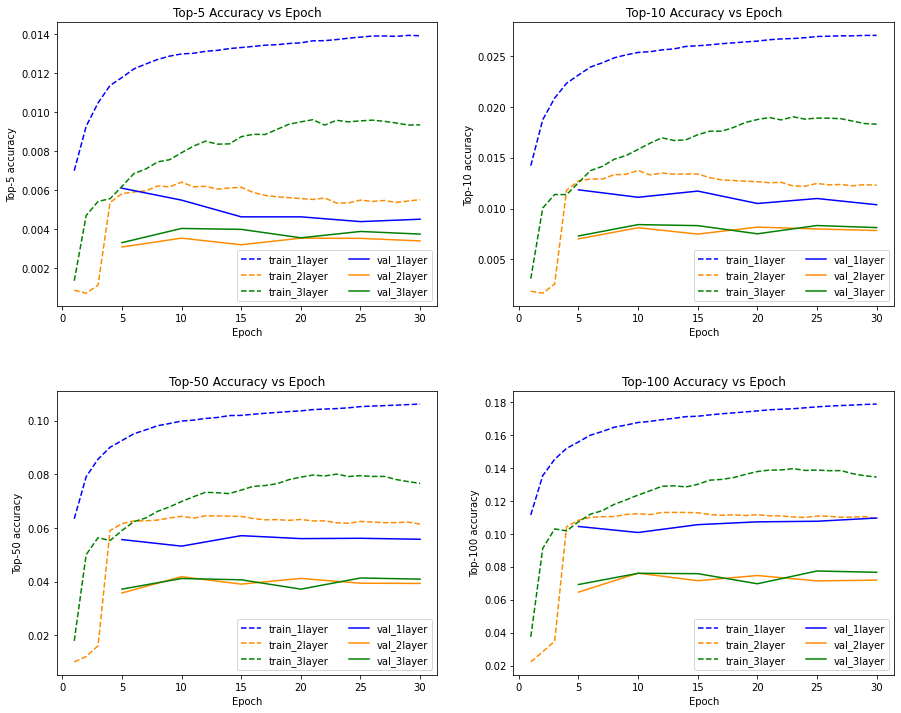

In [118]:
# Plot accuracy vs epoch
train_epochs = range(1, 31)
val_epochs = range(5, 31, 5)

fig, ax = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
ax = ax.ravel()

for i, k in enumerate(["5", "10", "50", "100"]):
    ax[i].plot(train_epochs, history_l1.history[f"factorized_top_k/top_{k}_categorical_accuracy"], label="train_1layer", ls="--", c="b")
    ax[i].plot(train_epochs, history_l2.history[f"factorized_top_k/top_{k}_categorical_accuracy"], label="train_2layer", ls="--", c="darkorange")
    ax[i].plot(train_epochs, history_l3.history[f"factorized_top_k/top_{k}_categorical_accuracy"], label="train_3layer", ls="--", c="g")
    ax[i].plot(val_epochs, history_l1.history[f"val_factorized_top_k/top_{k}_categorical_accuracy"], label="val_1layer", c="b")
    ax[i].plot(val_epochs, history_l2.history[f"val_factorized_top_k/top_{k}_categorical_accuracy"], label="val_2layer", c="darkorange")
    ax[i].plot(val_epochs, history_l3.history[f"val_factorized_top_k/top_{k}_categorical_accuracy"], label="val_3layer", c="g")
    ax[i].set_title(f"Top-{k} Accuracy vs Epoch")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel(f"Top-{k} accuracy")
    ax[i].legend(loc=4, ncol=2);

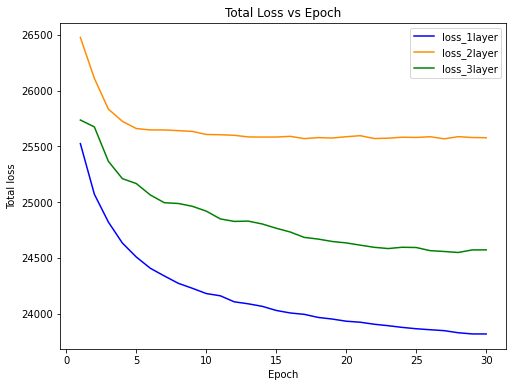

In [117]:
# Plot loss vs epoch
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(train_epochs, history_l1.history["total_loss"], label="loss_1layer", c="b")
ax.plot(train_epochs, history_l2.history["total_loss"], label="loss_2layer", c="darkorange")
ax.plot(train_epochs, history_l3.history["total_loss"], label="loss_3layer", c="g")
ax.set_title("Total Loss vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Total loss")
ax.legend(loc=1);

Comparing the metrics between the three models, we observed that the model with only a single layer in the neural network performed the best overall. The 1 layer model managed to achieve the highest top-k accuracy out of the three, and also the lowest total loss out of the three. This means that out of the three models, the 1 layer model is able to retrieve the highest percentage of items which are supposed to be the most appealing to the user. Having the lowest total loss would indicate that the 1 layer model is able to predict the ratings of the board games for the users with the least error.

Although we see extremely low top-5, top-10 accuracies, it is often not an issue for recommendation systems. Because most of the time, people do not end up buying the products that were recommended at the top of the recommendation lists. There are several other factors to consider as a consumer, such as diversity, novelty, serendipity, and relevance. Having a high accuracy in predicting very few items would not be as important. We can safely gauge our recommender system using the top-50 and top-100 accuracy metrics.

A low absolute value of top-k accuracy would simply mean that there is not enough data to work with. Due to limitations on computing power and a short timeframe, we trained the model using over 6 million user ratings on about 8,000 board games. These were the ratings within the past 3 years, there was over 38 million user ratings total. Furthermore, we used mostly explicit data such as the user ratings and board game features. It is possible to achieve higher accuracy scores if we had access to implicit data as well, like the time spent by user on some pages, or number of clicks for each board game thumbnail.

We evaluated the models using the top-k accuracy as it was part of the `tensorflow-recommenders` library. We acknowledge that there are also other metrics out there used to evaluate recommender systems, such as average reciprocal hit ranking (ARHR), mean average precision (MAP), mean average recall (MAR), etc., which could be explored further.

### Predictions

We will generate predictions using the 1 layer model and get a sensing of the recommended items.

In [119]:
# Create a model that takes in raw query features
deep_l1_index = tfrs.layers.factorized_top_k.BruteForce(deep_model_l1.query_model)

# Recommends a board game out of the entire boardgame dataset
deep_l1_index.index(tensor_candidates.batch(128).map(deep_model_l1.candidate_model), bgg_ids)

In [125]:
# Get recommendation
_, board_games = deep_l1_index({'bgg_user_name': tf.constant(['-mide-'])})

# Map the predicted bgg_id to the board game name
named_games = []
for bgg_id in board_games[0, :]:
    named_games.append(bg_mapper[bgg_id.numpy().decode("utf-8")])

print(f'Recommendations for -mide-: {named_games}')

Recommendations for -mide-: ['Catan: Starfarers', 'T.I.M.E Stories', 'New York Zoo', 'Exit: The Game – The Abandoned Cabin', 'Detective: A Modern Crime Board Game', 'Clank! Legacy: Acquisitions Incorporated', 'Sherlock Holmes Consulting Detective: Jack the Ripper & West End Adventures', 'Space Alert', 'Queendomino', 'Mansions of Madness: Second Edition']


In [126]:
# View the recommended board games with more info
df.loc[df['name'].isin(named_games), ['bgg_id', 'name', 'complexity', 'game_type', 'category', 'mechanic']]

,bgg_id,name,complexity,game_type,category,mechanic
1812,38453,Space Alert,2.9617,5496,"1072,1037,1016,1113","2689,2046,2023,2882,2040,2020,2819"
3621,146508,T.I.M.E Stories,2.6111,5496,"1022,1118,1028,1016","2023,2072,2027,2015"
5426,203420,Exit: The Game – The Abandoned Cabin,2.5538,"5496,5499","1039,1028,1037",2023
5454,204305,Sherlock Holmes Consulting Detective: Jack the...,2.1724,5496,"1039,1040,1093,2710,1028,1081","2023,2819,2027"
5490,205059,Mansions of Madness: Second Edition,2.6806,5496,"1022,1020,1010,1046,1024,1047,1040,1028","2046,2023,2072,2040,2011,2028,2822,2819,2019,2..."
5956,223321,Detective: A Modern Crime Board Game,2.7211,5496,"1039,1040","2023,2819,2027"
6231,232043,Queendomino,2.0970,5499,"1029,1010,1035,1086","2041,2043,2002,2079"
7197,266507,Clank! Legacy: Acquisitions Incorporated,2.7021,5496,"1022,1010","2041,2664,2824,2846,2078,2661"
7512,282853,Catan: Starfarers,2.3077,5499,"1020,1026,1016,1113","2026,2008"
7793,300877,New York Zoo,2.0851,5499,"1009,1089,1028","2903,2978,2011,2002"


In [127]:
# View the board games which '-mide-' has already rated for comparison
combined_df.loc[combined_df['bgg_user_name']=='-mide-', ['bgg_user_name', 'bgg_user_rating', 'bgg_id', 'name', 'complexity', 'game_type', 'category', 'mechanic']]

,bgg_user_name,bgg_user_rating,bgg_id,name,complexity,game_type,category,mechanic
1,-mide-,7.5,124,Primordial Soup,2.7308,5497,1036,"2957,2072,2676,2015"
2,-mide-,7.5,24480,The Pillars of the Earth,2.8201,5497,"1021,1035,1093,1115","2850,2985,2082,2933"
3,-mide-,7.0,37380,Roll Through the Ages: The Bronze Age,1.7782,"5497,5499","1050,1029,1015,1017","2072,2055,2870,2819"
4,-mide-,8.0,39683,At the Gates of Loyang,3.1290,5497,"1021,1013","2041,2912,2904,2900,2004,2819"
5,-mide-,8.0,54043,Jaipur,1.4935,5499,"1089,1052,1002,1021","2041,2040,2823,2004"
6,-mide-,8.0,83330,Mansions of Madness,3.2435,5496,"1022,1020,1010,1046,1024,1047,1040,1028","2046,2072,2040,2011,2007,2028,2822,2019,2015"
7,-mide-,7.5,102652,Sentinels of the Multiverse,2.4993,5496,"1002,1116,1046","2023,2040,2819,2015"
8,-mide-,8.5,128271,Ginkgopolis,2.9114,5497,"1029,1084,1016,1086","2080,2041,2020,2819,2002"
9,-mide-,8.5,161936,Pandemic Legacy: Season 1,2.8374,"5496,5497","1084,2145","2001,2023,2040,2824,2078,2004,2008,2015"
10,-mide-,8.0,161970,Alchemists,3.8997,5497,"1039,1010","2838,2041,2922,2875,2850,2040,2828"


We can observe that the model is clearly giving better recommendations after training for more number of epochs and adjusting the depth of the neural network. The top 10 recommended board games are of a similar game type, one that the user had rated highly for. The categories and mechanics are also similar to the highly rated board games. The user's highly rated games fall within the complexity range of about 2.0 to 3.0, which is synonyous with the complexity range of the recommended board games.